# VMO query/match function test

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import vmo.analysis as van
import vmo.generate as vge
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
import librosa, vmo
import IPython.display

%matplotlib inline

## Load wavfile and plot chroma

In [3]:
target_file = '../files/FunkBass.wav' 
qfilename = 'audio_query_test.wav'
sfilename = 'audio_shuffled_test.wav'

In [42]:
sample_rate = 22050
fft_size = 8192
hop_size = int(fft_size/2)

y, sr = librosa.load(target_file, sr=sample_rate)
C = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=fft_size, hop_length=hop_size, octwidth = None)
C = librosa.amplitude_to_db(C)
C = pre.normalize(C)

Text(0, 0.5, '2-norm')

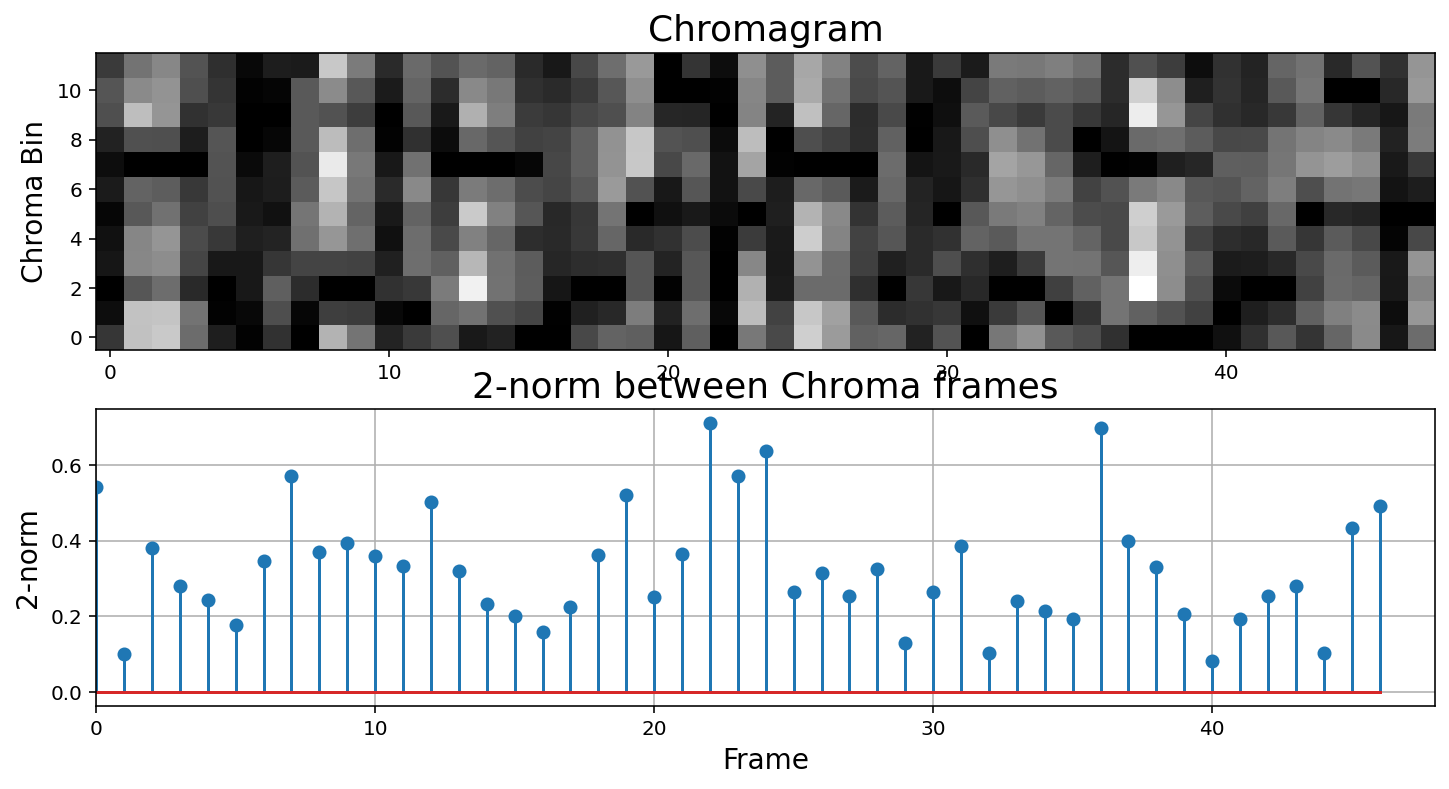

In [43]:
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.imshow(C, aspect = 'auto', origin = 'lower', interpolation = 'nearest', cmap ='Greys')
plt.title('Chromagram', fontsize = 18)
plt.ylabel('Chroma Bin', fontsize = 14)

plt.subplot(212)
plt.stem(np.sqrt(np.sum(np.diff(C)**2,0)))
plt.grid(b = 'on')
plt.xlim((0, C.shape[1]))
plt.title('2-norm between Chroma frames', fontsize = 18)
plt.xlabel('Frame', fontsize = 14)
plt.ylabel('2-norm', fontsize = 14)

## Calculate ideal threhold via IR

In [44]:
chroma_frames = C.transpose()
r = (0.0, 1.01, 0.01) 
ideal_t = vmo.find_threshold(chroma_frames, r = r,flag = 'a', dim=12)
oracle_t = vmo.build_oracle(chroma_frames, flag = 'a', threshold = ideal_t[0][1], feature = 'chroma', dim=12)

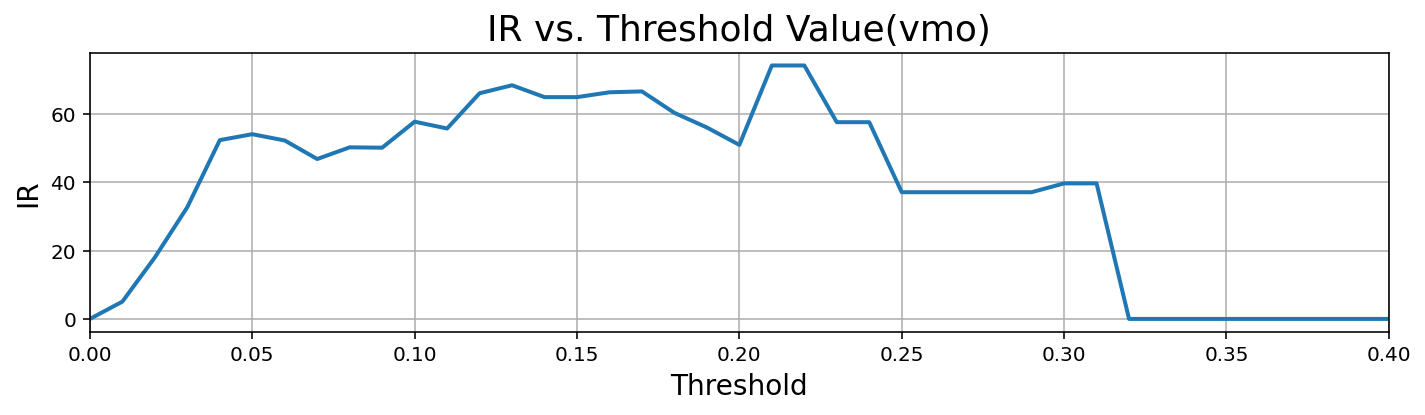

In [45]:
x = np.array([i[1] for i in ideal_t[1]])
y = [i[0] for i in ideal_t[1]]
fig = plt.figure(figsize = (10,3))
plt.plot(x, y, linewidth = 2)
plt.title('IR vs. Threshold Value(vmo)', fontsize = 18)
plt.grid(b = 'on')
plt.xlabel('Threshold', fontsize = 14)
plt.ylabel('IR', fontsize = 14)
plt.xlim(0, .4)
plt.tight_layout()

## Construct target Audio Oracle

In [25]:
from vmo.plot import start_draw
img = start_draw(oracle_t, size=(1600, 400))
print(img)

<PIL.Image.Image image mode=RGB size=1600x400 at 0x128C18110>


Text(0.5, 1.0, 'Oracle Structure')

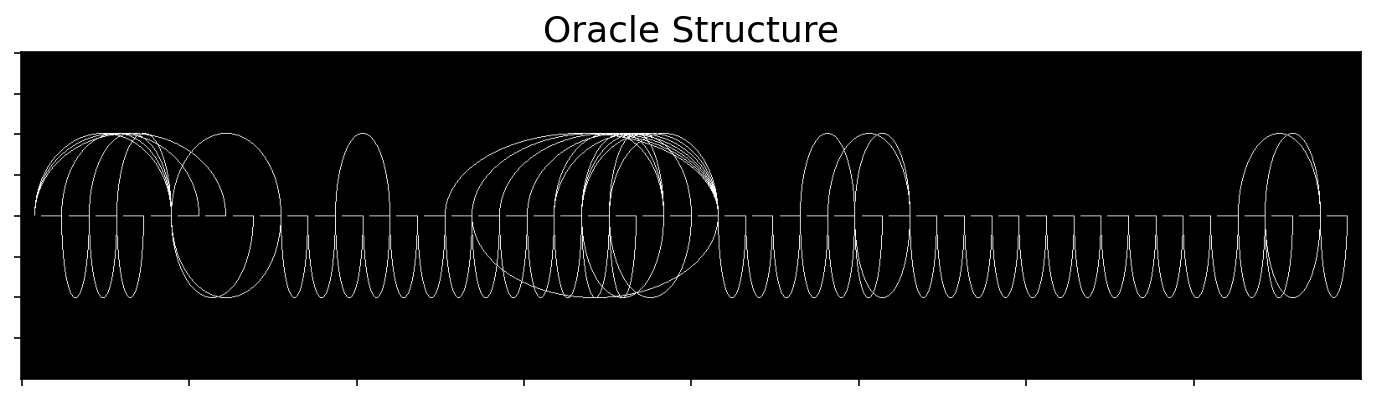

In [27]:
plt.figure(figsize=(12,3))
f = plt.gca()
plt.imshow(np.asarray(img), aspect = 'auto')
f.axes.xaxis.set_ticklabels([])
f.axes.yaxis.set_ticklabels([])
plt.title('Oracle Structure', fontsize = 18)

## Test with querying itself - perfect reconstruction expected

In [46]:
path_1, cost_1, i_hat_1 = van.query(oracle_t, chroma_frames)

In [47]:
print('=================')
print('Query with itself')
print('=================')
print('Perfect reconstruction:')
if path_1[i_hat_1] == range(1, oracle_t.n_states):
    print('Passed with cost '+ str(cost_1[i_hat_1]))
else:
    print('Failed with cost '+ str(cost_1[i_hat_1]))

Query with itself
Perfect reconstruction:
Failed with cost 0.0


## Test with shuffled version

By current query/matching strategy, the query is sub optimal in the sense that it only considers forward links and the current state as possible next state, but the shuffled sequence generated by PyOracle could have the next state the forward states along the suffix links. I.e, for state k, the query function considers {trn[k],k} as possible next state while the generate function in PyOracle considers trn[sfx[k]] as possible next state as well. 

In [56]:
s, _kend, _ktrace = vge.generate(oracle_t, 20, p=0.5, k=1, LRS=2, weight='weight')

query_features = [chroma_frames[_s-1] for _s in s]

path, cost, i_hat = van.query(oracle_t, query_features)

print('============================')
print('Query with shuffled original')
print('============================')
print('Perfect reconstruction:')
if path[i_hat] == s:
    print('Passed with cost '+ str(cost[i_hat]))
else:
    print('Failed with cost '+ str(cost[i_hat]))
print('Retrieved path: ', path[i_hat])
print('Shuffled path:  ', s)

Query with shuffled original
Perfect reconstruction:
Passed with cost 0.0
Retrieved path:  [2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 17, 25, 27, 29, 32, 33, 34, 35]
Shuffled path:   [2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 17, 25, 27, 29, 32, 33, 34, 35]


In [57]:
vge.audio_synthesis(target_file, qfilename, path[i_hat], sample_rate, fft_size, hop_size)
vge.audio_synthesis(target_file, sfilename, s, sample_rate, fft_size, hop_size)

(array([-3.7266042e-07, -4.1124645e-07, -4.7042667e-07, ...,
         4.7799599e-06,  4.7523099e-06,  4.7423882e-06], dtype=float32),
 array([1.00000000e-05, 1.01471045e-05, 1.05884178e-05, ...,
        1.05884178e-05, 1.01471045e-05, 1.00000000e-05]),
 22050)